#Ising model using SPPARKS

In this example we will take a look at the simulated data. Data was obtained using SPPARKS kinetic Monte-Carlo simulator for 2 phase ising model. The model is 2D and the volume fraction of one phase is varied for different simulations. Microstructures are assumed to be periodic.

###Data loading

First, we load the data:

In [2]:
from pymks_share import DataManager
import numpy as np

manager = DataManager('pymks.me.gatech.edu')
X = manager.fetch_data('2 phase ising model')
Y = manager.fetch_data('Ising 30%')
Z = manager.fetch_data('ising 10%')
R1 = manager.fetch_data('Ising 40%_Run#1')
R2 = manager.fetch_data('Ising 40%_Run#3')
X.shape, R1.shape 

((201, 100, 100), (201, 100, 100))

`X` refers to 50% volume fraction and the rest of the data has its volume fraction in its name.

Let's take a look how initial microstructures look like for three different volume fractions (50%, 30%, 10%) using `draw_microstructures`:

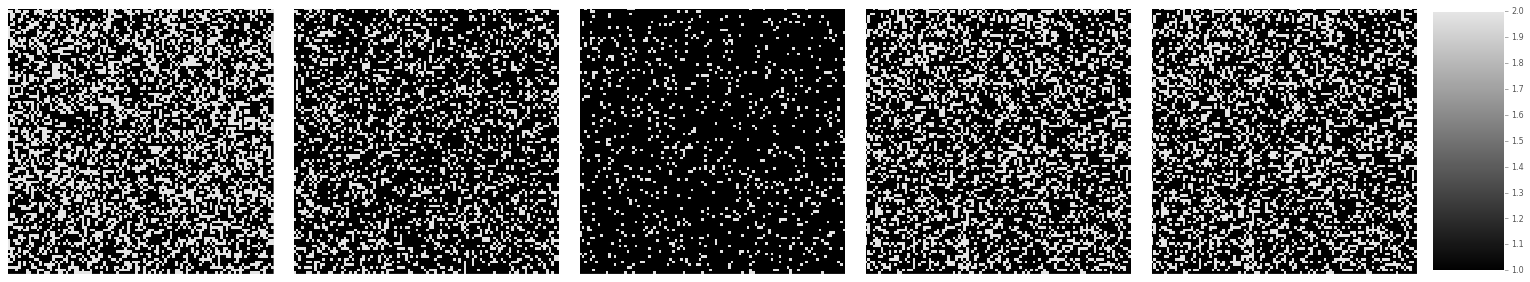

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pylab as plt
from pymks.tools import draw_microstructures

X_con = np.concatenate((X, Y, Z, R1, R2))
draw_microstructures((X_con[::201]))

And the corresponding final microstructures after simulation (200 Monte-Carlo steps) look like these:

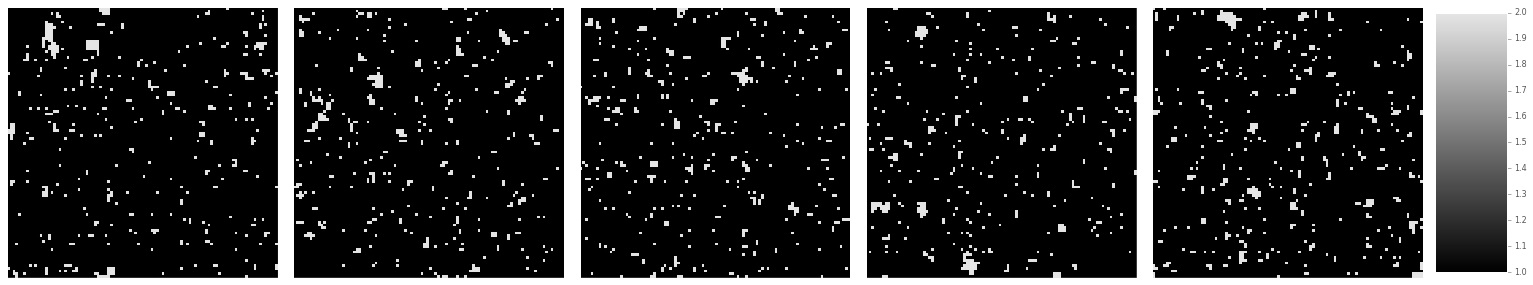

In [4]:
draw_microstructures((X_con[200::201]))

So, this is a microstructure evolution problem, and final microstructures look very similar to each other (just looking at them). Can we check it using PyMKS tools? We have 200 files (microstructure outputs) for each simulation at every fixed Monte-Carlo step, so we can also take a look at path each simulation takes.

###Microstructure Statistics 

To get started, we are going to perform 2-point statistics first for couple of microstructures using `correlate` from `pymks.stats` :

The correlations can be plotted using `draw_autocorrelations` from `pymks.tools`. Here 10th step is plotted since initial is completely random microstructure and its statistics does not look exciting. So, we are going to take a look at 10th Monte-Carlo step output. 

In [5]:
from pymks import PrimitiveBasis
from pymks.stats import correlate
from pymks.tools import draw_autocorrelations

prim_basis = PrimitiveBasis(n_states=2,domain=[1, 2])
X_ = prim_basis.discretize(X)
X_auto = correlate(X_, periodic_axes=(0, 1), correlations=[(0, 0),(1, 1)])

X_auto.shape

(201, 100, 100, 2)

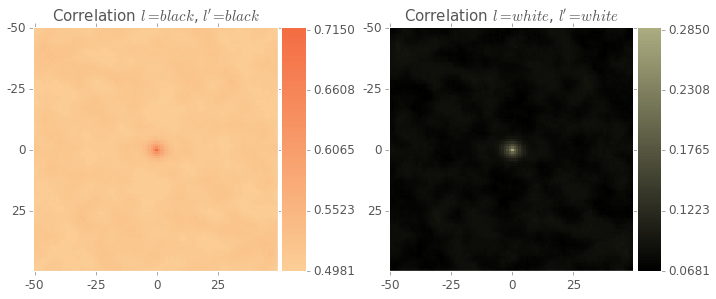

Volume fraction of black phase 0.6099
Volume fraction of white phase 0.3901


In [6]:
correlations = [('black', 'black'), ('white', 'white')]
draw_autocorrelations(X_auto[10], autocorrelations=correlations)

center = (X_auto.shape[2]) / 2
print 'Volume fraction of black phase', X_auto[0, center, center, 0]
print 'Volume fraction of white phase', X_auto[0, center, center, 1]

Let's also plot 2-point statistics of the final microstructure for the same simulation. They do not look much interesting since it's mostly has black state:

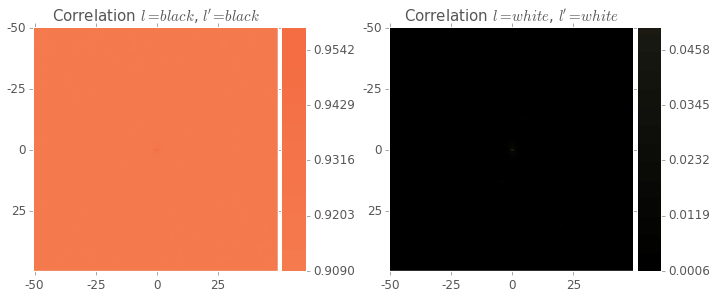

Volume fraction of black phase 0.9542
Volume fraction of white phase 0.0458


In [7]:
draw_autocorrelations(X_auto[200], autocorrelations=correlations)
print 'Volume fraction of black phase', X_auto[200, center, center, 0]
print 'Volume fraction of white phase', X_auto[200, center, center, 1]

###Reduced-order representations (PCA)

Using `MKSStructureAnalysis` we can perform 2-points statistics and dimentionality reduction (PCA) right after. So we are not going to use whatever we have done in the previous section, it was just to show how 2-point statistics look like for our data.
So, total we have 5 simulations and they already have been concatenated into X_con.

In [8]:
from pymks import MKSStructureAnalysis

leg_basis = PrimitiveBasis(n_states=2, domain=[1, 2])
analyzer = MKSStructureAnalysis(basis=leg_basis)

XY_PCA=analyzer.fit_transform(X_con,periodic_axes=[0,1])
XY_PCA.shape

(1005, 5)

R1 and R2 are two different simulation results with the same initial microstructure, but different seeds for random number generation for Monte-Carlo simulations. The hope is to see that the same initial microstructure will take two different paths and will end up in quite the same spot. Let's check it!

So let's take a look at PCA plot:

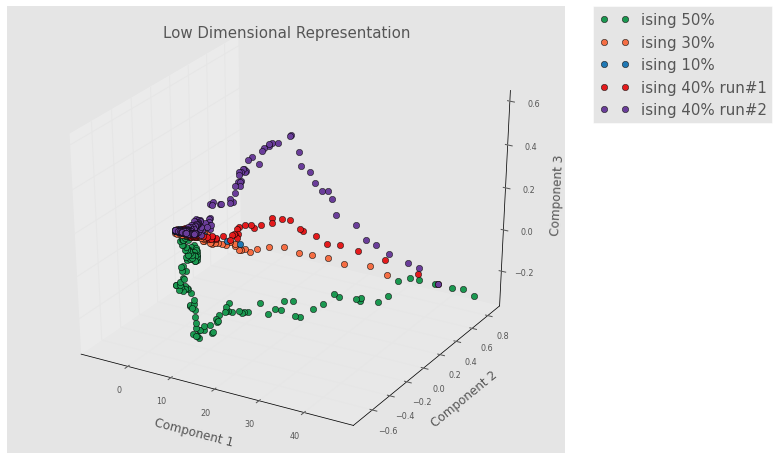

In [9]:
from pymks.tools import draw_components

draw_components([XY_PCA[0:201, :3], XY_PCA[201:402, :3], XY_PCA[402:603, :3],
                 XY_PCA[603:804, :3], XY_PCA[804:1005, :3]],
                ['ising 50%', 'ising 30%', 'ising 10%',
                 'ising 40% run#1', 'ising 40% run#2'], 
                view_angles=(30,-60), legend_outside=True, fig_size=(10,8))

Looks cool but not clear! Now, let's plot only initial and final structures.

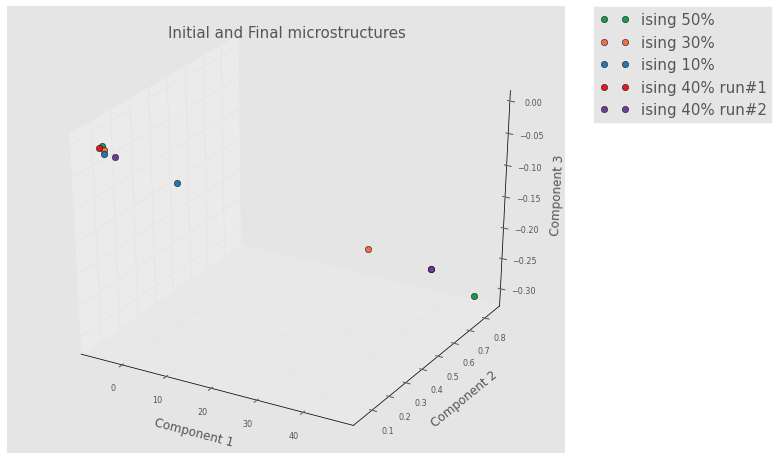

In [11]:
draw_components([XY_PCA[:201:200, :3], XY_PCA[201:402:200, :3],
                 XY_PCA[402:603:200, :3], XY_PCA[603:804:200, :3],
                 XY_PCA[804:1005:200, :3]],
                ['ising 50%','ising 30%','ising 10%','ising 40% run#1'
                 ,'ising 40% run#2'],
                view_angles=(30,-60), legend_outside=True,
                fig_size=(10,8), title='Initial and Final microstructures')

The clustering on the top left side is final structures, while the spread is initial structures. Note: there are only four initial visible structures since two last runs start with the same initial microstructures. 

From these five simulations we can tell that different initial microstructures merge into similar ones after Monte-Carlo simulations although they take different paths.